<!-- <img src="./images/DLI_Header.png" style="width: 400px;"> -->
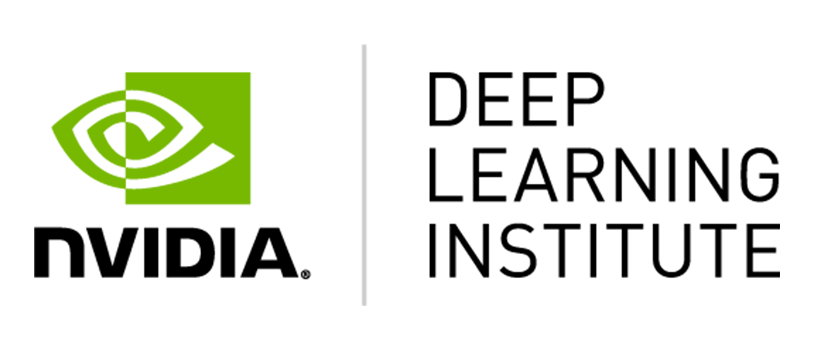

In [ ]:
!git clone https://github.com/jhkim3217/data.git

Cloning into 'data'...
remote: Enumerating objects: 13808, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13808 (delta 1), reused 6 (delta 1), pack-reused 13802
Receiving objects: 100% (13808/13808), 1.83 GiB | 26.94 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (13777/13777), done.


# 데이터 증강

지금까지는 모델의 성능을 크게 개선하는 모델 아키텍처를 선택했습니다. 이러한 아키텍처는 이미지의 중요한 특징을 인식하도록 설계되었기 때문입니다. 검증 정확도는 여전히 트레이닝 정확도에 미치지 못하고 있으며, 이는 과적합의 징후입니다. 모델이 검증 데이터세트에 대한 테스트를 진행할 때 처음 접하는 항목들로 인해 혼란을 겪는 것입니다.

모델이 새로운 데이터를 살펴볼 때 좀 더 강력한 성능을 발휘하도록 가르치기 위해 우리는 데이터세트에서 크기와 편차를 프로그래밍 방식으로 늘릴 것입니다. 이를 [*데이터 증강*](https://link.springer.com/article/10.1186/s40537-019-0197-0) (Data Augmentation)이라고 하며, 데이터 증강은 다수의 딥러닝 애플리케이션을 위한 유용한 기술입니다.

크기가 증가하면 모델은 트레이닝 중에 더 많은 이미지를 학습하게 됩니다. 편차 증가는 모델이 중요하지 않은 특징을 무시하고 분류에서 정말로 중요한 특징만 선택하도록 하여 더 나은 일반화가 가능하게 합니다.

## 목표

* ASL 데이터세트 증강
* 증강된 데이터를 사용하여 개선된 모델 트레이닝
* 제대로 트레이닝된 모델을 디스크에 저장하여 배포에 사용

## 데이터 준비

새 노트북이므로, 데이터를 다시 로드하여 처리하겠습니다. 이렇게 하려면 다음 셀을 실행합니다.

In [4]:
import tensorflow.keras as keras
import pandas as pd
from tensorflow.keras.utils import plot_model
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load in our data from CSV files
train_df = pd.read_csv("../2023_05_24/data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("../2023_05_24/data/asl_data/sign_mnist_valid.csv")
display(train_df.head())
display(train_df.tail())
display(train_df.describe())
display(train_df['label'])

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
27450,12,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,22,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,17,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,16,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93
27454,22,179,180,180,180,182,181,182,183,182,...,108,132,170,194,214,203,197,205,209,215


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,11.679476,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,6.880558,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,12.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,18.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,23.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


0         3
1         6
2         2
3         2
4        12
         ..
27450    12
27451    22
27452    17
27453    16
27454    22
Name: label, Length: 27455, dtype: int64

In [5]:
# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
print(y_train.values)

del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values
print(x_train.shape)
print(y_train.shape)

[ 3  6  2 ... 17 16 22]
(27455, 784)
(27455,)


In [6]:
# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network, (27455, 784)
x_train = x_train.reshape(-1,28,28,1)  # (27455, 28, 28, 1) 28x28 =784
x_valid = x_valid.reshape(-1,28,28,1)

print(x_train.shape)
print(x_valid.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


## 모델 생성

모델도 다시 생성해야 합니다. 이렇게 하려면 다음 셀을 실행합니다. 이는 지난 섹션과 동일한 모델 아키텍처입니다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(MaxPooling2D((2, 2), strides=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(MaxPooling2D((2, 2), strides=2))
model.add(MaxPooling2D(2))

model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
# model.add(MaxPool2D((2, 2), strides=2, padding="same"))
# model.add(MaxPooling2D((2, 2), strides=2))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

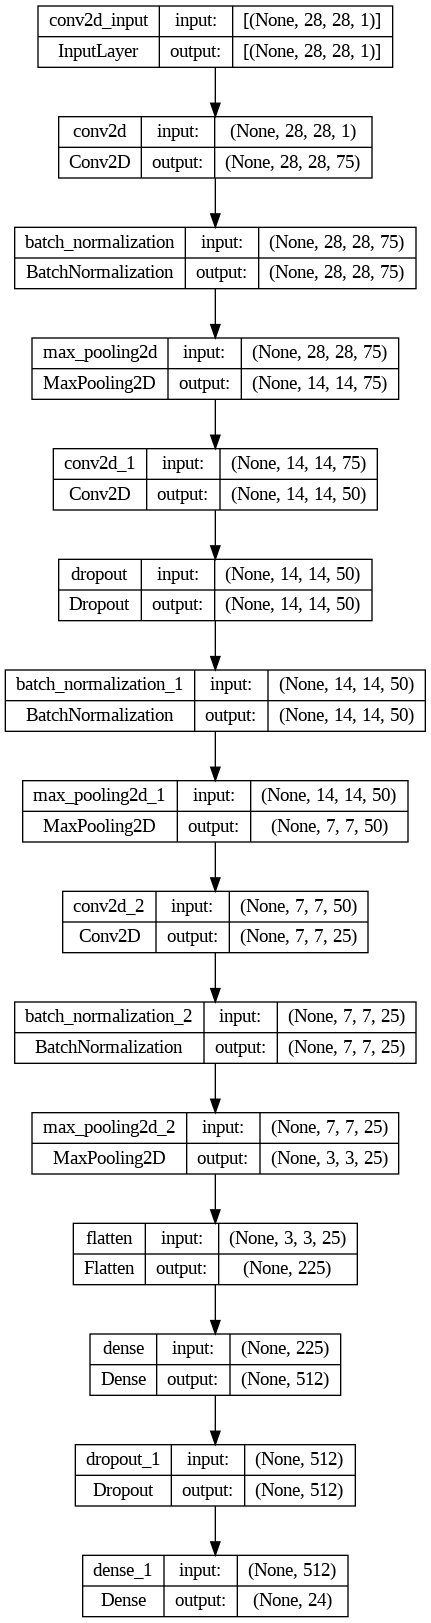

In [ ]:
plot_model(model, show_shapes=True)

## 데이터 증강

모델을 컴파일하기 전에 데이터 증강을 설정해야 합니다.

Keras에는 `ImageDataGenerator`라는 이미지 증강 클래스가 포함되어 있습니다. [여기에 있는 문서](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)를 참조하십시오. 이 클래스는 데이터 증강을 위한 일련의 옵션을 허용합니다. 과정 후반부에서 적합한 증강 전략을 선택해야 합니다. 일단은 아래에서 선택한 옵션을 살펴본 다음 셀을 실행하여 클래스의 인스턴스를 생성해 보겠습니다.

In [7]:
# ImageDataGenerator : 데이터 증강 클래스
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)  

잠시 시간을 내어 이미지를 세로가 아닌 가로로 반전해야 하는 이유에 대해 생각해 보십시오. 이유가 떠오르면 아래 텍스트를 표시합니다.

데이터세트는 알파벳을 손으로 나타내는 그림입니다. 이 모델을 사용하여 나중에 손 이미지를 분류하려는 경우 손의 위아래가 바뀔 가능성은 적지만 왼손잡이로 전환될 수는 있습니다. 이렇게 분야별 추론은 자체적인 딥러닝 애플리케이션과 관련된 적절한 결정을 내릴 수 있게 도와줍니다.

## 배치 크기
`ImageDataGenerator`의 또 다른 이점은 모델이 무작위 샘플에 대해 트레이닝할 수 있도록 데이터를 [배치 처리](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/)한다는 점입니다.

모델이 [진정한 무작위](http://sites.utexas.edu/sos/random/)여서 데이터가 제대로 섞이고 한 벌의 카드처럼 공평한 경우에는 모집단의 일부임에도 불구하고 샘플이 모든 데이터를 제대로 표현할 수 있습니다. 트레이닝의 각 단계에서는 모델이 새로운 배치로 처리됩니다.

실제로는 32 및 64의 배치 크기도 괜찮습니다. 아래 셀을 실행하여 모델을 어떤 유형의 배치로 트레이닝하게 될지 확인하십시오. Randomizer가 제대로 무작위성을 발휘하고 있습니까? 모든 이미지가 인식 가능한 ASL 문자입니까?

(32, 28, 28, 1)
(32, 24)


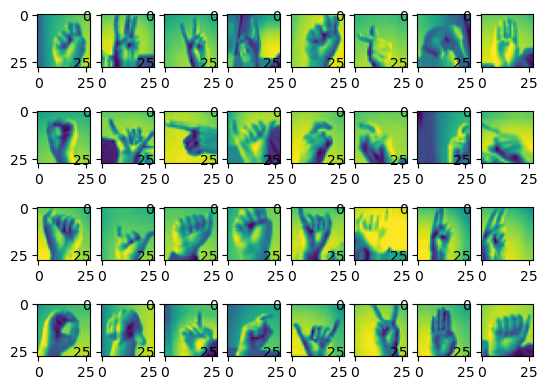

In [8]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
print(x.shape)
print(y.shape)

fig, ax = plt.subplots(nrows=4, ncols=8)

for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## 데이터를 생성기에 맞추기

이제 생성기를 트레이닝 데이터세트에 맞춰야 합니다.

In [9]:
datagen.fit(x_train)

## 모델 컴파일

데이터 생성기 인스턴스를 생성하여 트레이닝 데이터에 맞췄으니 이제 이전의 예에서와 동일한 방식으로 모델을 컴파일할 수 있습니다.

In [10]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'model' is not defined

## 증강으로 트레이닝

Keras에 이미지 데이터 생성기를 사용하는 경우 모델은 약간 다른 방식으로 트레이닝합니다. 즉, 단순히 `x_train` 및 `y_train` 데이터세트를 모델에 전달하는 대신 생성기를 전달하여 생성기의 [flow](https://keras.io/api/preprocessing/image/) 메서드를 호출합니다. 그러면 이미지가 트레이닝을 위해 모델에 전달되기 직전에 실시간으로 증강되어 메모리에 위치합니다.

생성기(Generator)는 무한한 데이터를 공급할 수 있으므로 생성기를 사용하여 데이터를 트레이닝할 때는 각 에포크가 얼마나 오랫동안 실행되어야 하는지를 명시적으로 설정해야 합니다. 그렇지 않으면 에포크가 무한히 실행되고 생성기는 모델을 제공하기 위해 증강된 이미지를 무한정으로 생성합니다.

여기서는 `steps_per_epoch`라는 인수를 사용하여 각 에포크가 얼마나 오랫동안 실행되어야 하는지를 명시적으로 설정했습니다. 여기서 사용할 일반적인 방식인 `steps * batch_size = number_of_images_trained in an epoch`는 단계 수를 증강되지 않은 데이터세트 크기를 batch_size(기본값 32)로 나눈 값과 동일하게 설정하는 것이기 때문입니다.

다음 셀을 실행하여 결과를 확인합니다. 트레이닝이 전보다 오래 걸리는 이유는 전보다 많은 데이터에 대한 트레이닝을 진행해야 하기 때문입니다.

In [ ]:
hist = model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/20
857/857 [==============================] - 24s 16ms/step - loss: 1.1061 - accuracy: 0.6418 - val_loss: 0.3619 - val_accuracy: 0.8777
Epoch 2/20
857/857 [==============================] - 13s 15ms/step - loss: 0.3140 - accuracy: 0.8938 - val_loss: 0.6319 - val_accuracy: 0.8086
Epoch 3/20
857/857 [==============================] - 13s 15ms/step - loss: 0.1865 - accuracy: 0.9370 - val_loss: 0.0857 - val_accuracy: 0.9682
Epoch 4/20
857/857 [==============================] - 13s 15ms/step - loss: 0.1431 - accuracy: 0.9529 - val_loss: 0.3333 - val_accuracy: 0.9084
Epoch 5/20
857/857 [==============================] - 13s 16ms/step - loss: 0.1155 - accuracy: 0.9625 - val_loss: 0.7620 - val_accuracy: 0.8027
Epoch 6/20
857/857 [==============================] - 13s 15ms/step - loss: 0.1017 - accuracy: 0.9671 - val_loss: 2.0631 - val_accuracy: 0.6748
Epoch 7/20
857/857 [==============================] - 13s 16ms/step - loss: 0.0938 - accuracy: 0.9689 - val_loss: 0.0821 - val_accuracy:

Text(0.5, 1.0, 'Loss')

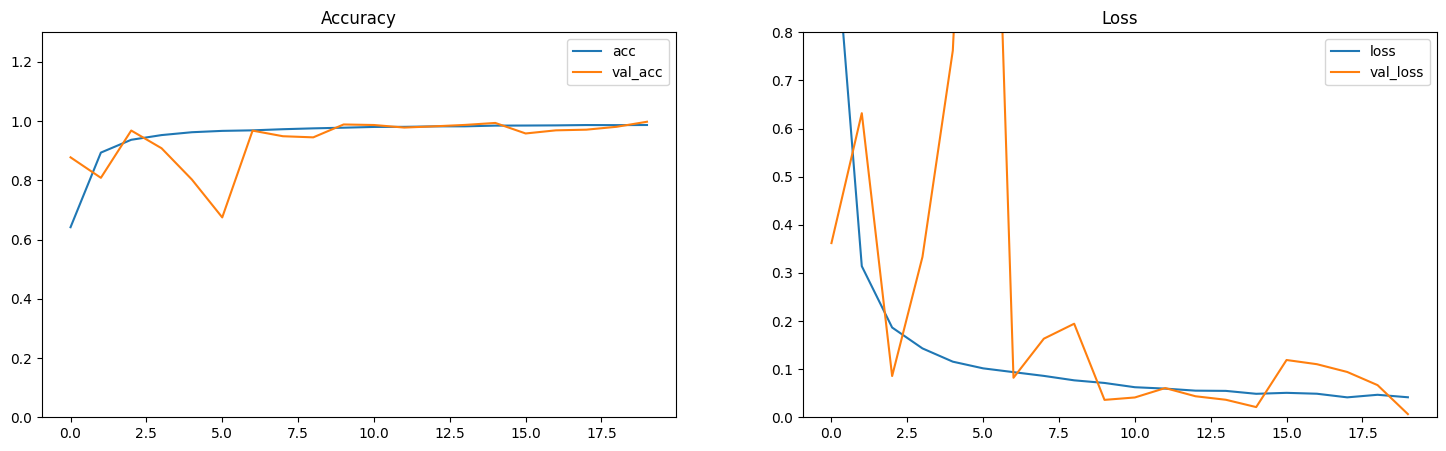

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plt.ylim(0, 1.3)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.ylim(0, 0.8)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')

## 결과에 대한 논의

검증 정확도가 더 높고, 더 일관적임을 확인할 수 있습니다. 이는 모델이 더 이상 전에 비해 과적합 상태를 보이지 않음을 의미합니다. 즉, 일반화가 개선되었고 새 데이터에 대한 예측도 개선되었습니다.

## 모델 저장

제대로 트레이닝된 모델을 얻었으니 이제 이를 배포하여 새 이미지에 대한 추론을 수행해야 합니다.

만족스럽게 학습된 모델은 보통 디스크에 저장하게 됩니다.

Keras에서는 저장 메서드를 사용하여 모델을 쉽게 저장할 수 있습니다. 저장 가능한 다양한 형식이 있지만 일단은 기본 형식을 사용하겠습니다. 원하는 경우 언제든지 [문서](https://www.tensorflow.org/guide/keras/save_and_serialize)를 참조하십시오. 다음 노트북에서는 모델을 로드한 후 이를 사용하여 새로운 수화 그림을 읽어보겠습니다.

In [ ]:
# model.save('asl_model')
# Keras Model save / load_model
model.save('asl.h5')

## 요약

이 섹션에서는 Keras를 사용하여 데이터세트를 증강했으며, 그 결과 과적합이 감소한 트레이닝된 모델과 뛰어난 검증 이미지 결과를 얻었습니다.

### 메모리 지우기
넘어가기 전에 다음 셀을 실행하여 GPU 메모리를 지워주시기 바랍니다.

## 다음

제대로 트레이닝된 모델이 디스크에 저장되었으니 다음 섹션에서는 모델을 배포하여 처음 접하는 이미지에 대한 예측을 수행하겠습니다.

이어서 다음 노트북인 [*모델 예측*](04b_asl_predictions.ipynb)을 계속 진행해 주십시오.